In [76]:
import os
import re
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from collections import namedtuple
from IPython.core.display import display, HTML
  
sys.path.append('/app/src')
sys.path.append('/app/src/utils')
warnings.filterwarnings("ignore")

In [77]:
result_root_dir = "/app/outputs/KITTI/errors/errors_for_eval/vo_dropout"
ekf_result_root_dir = os.path.join(result_root_dir, "ekf")
ekf_straight = os.path.join(ekf_result_root_dir, "straight")
ekf_curved = os.path.join(ekf_result_root_dir, "curved")

ckf_result_root_dir = os.path.join(result_root_dir, "ckf")
ckf_straight = os.path.join(ckf_result_root_dir, "straight")
ckf_curved = os.path.join(ckf_result_root_dir, "curved")

In [78]:
os.path.exists(ckf_curved)

True

Sequence: 	 9 

Trans. err. (%): 	 6.193 

Rot. err. (deg/100m): 	 2.403 

ATE (m): 	 26.176 

RPE (m): 	 0.263 

RPE (deg): 	 0.235 


In [79]:
ResultField = namedtuple('ResultField', ('seq', 'trans_error', 'rot_error', 'ATE', 'RPE_m', 'RPE_deg'))
indices = ["Trans. err. (%)", "Rot. err. (deg/100m)", "ATE (m)", "RPE (m)", "RPE (deg)"]
columns = ["No data drop", "10", "20", "40", "80", "160"]

In [80]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [81]:
def parse_result_file(filename: str) -> List[ResultField]:
    results = []

    with open(filename, "r") as f:
        result = ()
        for line in f:
            line = re.split(r': \t ', line)
            if len(line) == 2:
                line = line[-1]
                result = result + (float(line), )
            else:
                results.append(ResultField(*result))
                result = ()

    return results


In [82]:
def get_result_df(experiment_path: str, with_index: bool=False) -> pd.DataFrame:
    result_dict = dict()
    for root, dirs, files in os.walk(experiment_path):
        path = root.split(os.sep)
        if len(path) == 10:
            drop = path[-1]
            filepath = "/".join(path)
        for file in files:
            if file == "result.txt":
                result_filepath = os.path.join(filepath, file)
                result = parse_result_file(result_filepath)
                result_dict[int(drop)] = result
    
    values = []
    for (drop, results) in sorted(result_dict.items()):
        result = results[0]
        val = np.array([
            result.trans_error,
            result.rot_error,
            result.ATE,
            result.RPE_m,
            result.RPE_deg
        ])
        values.append(val)
    
    values = np.array(values).T
    
    return pd.DataFrame(values, columns=columns, index=indices) if with_index else pd.DataFrame(values, columns=columns)

In [83]:
ekf_straight_df = get_result_df(ekf_straight)
ekf_curved_df = get_result_df(ekf_curved)

ckf_straight_df = get_result_df(ckf_straight)
ckf_curved_df = get_result_df(ckf_curved)

In [84]:
ekf_straight_df_for_display = get_result_df(ekf_straight, with_index=True)
ekf_curved_df_for_display = get_result_df(ekf_curved, with_index=True)

ckf_straight_df_for_display = get_result_df(ckf_straight, with_index=True)
ckf_curved_df_for_display = get_result_df(ckf_curved, with_index=True)

display(HTML(f"<h2 style='text-align: left; margin-left: 390px;'>EKF estimation by VO data drop in different location</h2>"))
display_side_by_side([ekf_straight_df_for_display, ekf_curved_df_for_display], 
                     ['EKF estimation with drop at straight trajectory', 'EKF estimation with drop at curved trajectory'])
display(HTML(f"<div style='margin-bottom: 40px;'></div>"))

display(HTML(f"<h2 style='text-align: left; margin-left: 390px;'>CKF estimation by VO data drop in different location</h2>"))
display_side_by_side([ckf_straight_df_for_display, ckf_curved_df_for_display], 
                     ['CKF estimation with drop at straight trajectory', 'CKF estimation with drop at curved trajectory'])
display(HTML(f"<div style='margin-bottom: 40px;'></div>"))

,No data drop,10,20,40,80,160
Trans. err. (%),7.167000,6.193000,6.494000,6.575000,7.199000,8.420000
Rot. err. (deg/100m),2.403000,2.403000,2.403000,2.403000,2.403000,2.403000
ATE (m),16.696000,26.176000,30.254000,29.045000,30.609000,35.652000
RPE (m),0.275000,0.263000,0.263000,0.263000,0.267000,0.264000
RPE (deg),0.235000,0.235000,0.235000,0.235000,0.235000,0.235000
,No data drop,10,20,40,80,160
Trans. err. (%),7.167000,6.066000,6.057000,6.330000,7.546000,11.034000
Rot. err. (deg/100m),2.403000,2.403000,2.403000,2.403000,2.403000,2.403000
ATE (m),16.698000,14.692000,14.592000,16.483000,23.161000,51.527000
RPE (m),0.276000,0.271000,0.270000,0.275000,0.285000,0.305000


,No data drop,10,20,40,80,160
Trans. err. (%),7.080000,7.229000,7.726000,7.627000,7.447000,10.348000
Rot. err. (deg/100m),3.617000,3.615000,3.658000,3.657000,3.673000,3.649000
ATE (m),16.719000,21.239000,24.758000,23.851000,23.004000,37.165000
RPE (m),0.106000,0.103000,0.107000,0.107000,0.109000,0.157000
RPE (deg),0.612000,0.609000,0.608000,0.602000,0.587000,0.562000
,No data drop,10,20,40,80,160
Trans. err. (%),7.035000,7.307000,7.295000,7.905000,10.910000,23.747000
Rot. err. (deg/100m),3.614000,3.599000,3.596000,3.586000,3.620000,3.795000
ATE (m),16.718000,21.154000,21.329000,26.970000,49.630000,153.730000
RPE (m),0.105000,0.120000,0.122000,0.136000,0.167000,0.294000


In [85]:
def split_df(straight_df, curved_df):
    df_by_metric = dict()
    for i, index in enumerate(indices):
        straight = straight_df.iloc[i:i+1].copy()
        curved = curved_df.iloc[i:i+1].copy()
        straight.rename({i: "Straight"}, inplace=True)
        curved.rename({i: "Curved"}, inplace=True)
        df_by_metric[index] = pd.concat([straight, curved], axis=0)

    return df_by_metric

In [86]:
ekf_df_by_metric = split_df(ekf_straight_df, ekf_curved_df)
ckf_df_by_metric = split_df(ckf_straight_df, ckf_curved_df)

# EKF

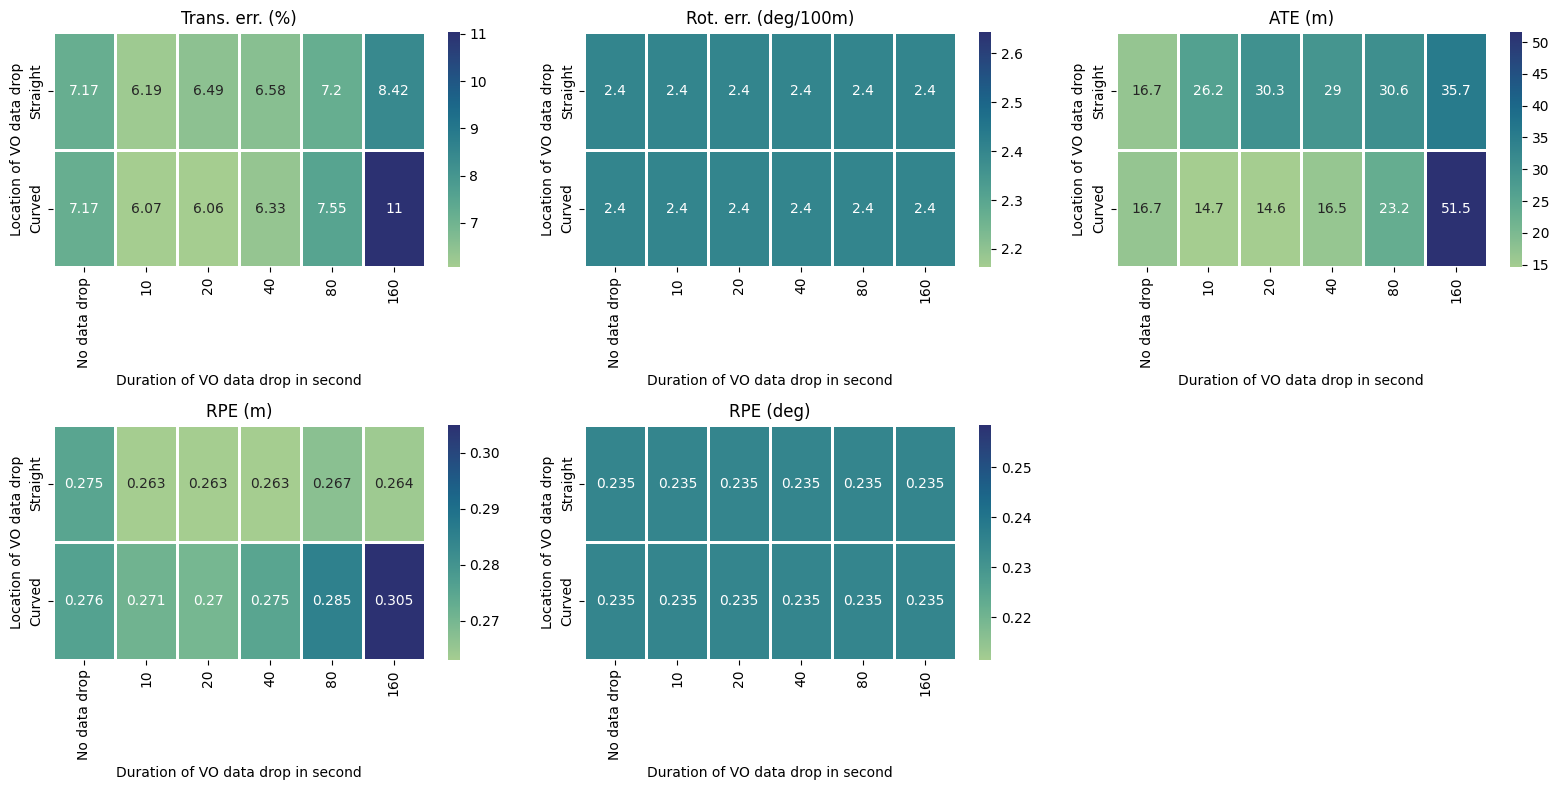

In [87]:
# Create a figure with specified layout
fig, (row1, row2) = plt.subplots(2, 3, figsize=(16, 8))
xlabel_text = "Duration of VO data drop in second"
ylabel_text = "Location of VO data drop"
for i, metric_name in enumerate(indices[:3]):
    # Plot the heatmaps
    sns.heatmap(
        ekf_df_by_metric[metric_name], 
        ax=row1[i], 
        cmap="crest",
        annot=True,
        linewidths=1,
        fmt='.3g',
    )
    
    row1[i].title.set_text(metric_name)
    row1[i].set(xlabel=xlabel_text, ylabel=ylabel_text)
    # Add a colorbar to the dedicated colorbar axis
    cmap = cm.get_cmap("crest")

for i, metric_name in enumerate(indices[3:]):
    # Plot the heatmaps
    sns.heatmap(
        ekf_df_by_metric[metric_name], 
        ax=row2[i], 
        cmap="crest",
        annot=True,
        linewidths=1,
        fmt='.3g',
    )

    row2[i].title.set_text(metric_name)   
    # Add a colorbar to the dedicated colorbar axis
    cmap = cm.get_cmap("crest")
    row2[i].set(xlabel=xlabel_text, ylabel=ylabel_text)

fig.delaxes(row2[2])
plt.tight_layout()
plt.show()


In [88]:
# Create a figure with specified layout
def visualize_metric_on_heatmap(df_by_metric, selected_metric_names):
    num_metrics = len(selected_metric_names)
    height = 2.5 * num_metrics
    fig, axs = plt.subplots(num_metrics, 1, figsize=(12, height))
    
    for i, metric_name in enumerate(selected_metric_names):
        ax = axs[i] if num_metrics > 1 else axs
        # Plot the heatmaps
        sns.heatmap(
            df_by_metric[metric_name], 
            ax=ax, 
            cmap="crest",
            annot=True,
            linewidths=1,
            fmt='.3g',
        )
        
        ax.title.set_text(metric_name)
        ax.set(xlabel=xlabel_text, ylabel=ylabel_text)
        # Add a colorbar to the dedicated colorbar axis
        cmap = cm.get_cmap("crest")
    
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(num_metrics, 1, figsize=(10, height))
    
    for i, metric_name in enumerate(selected_metric_names):
        ax = axs[i] if num_metrics > 1 else axs
        x_axis = df_by_metric[metric_name].columns
        ax.plot(x_axis, df_by_metric[metric_name].iloc[0].values, label="VO data drop at straight trajectory")
        ax.plot(x_axis, df_by_metric[metric_name].iloc[1].values, label="VO data drop at curved trajectory")
        ax.set(xlabel="Duration of data drop in second", ylabel=metric_name)
        ax.title.set_text(f"Comparison of estimation in {metric_name} with different duration of data drop")
        ax.grid()
        ax.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()


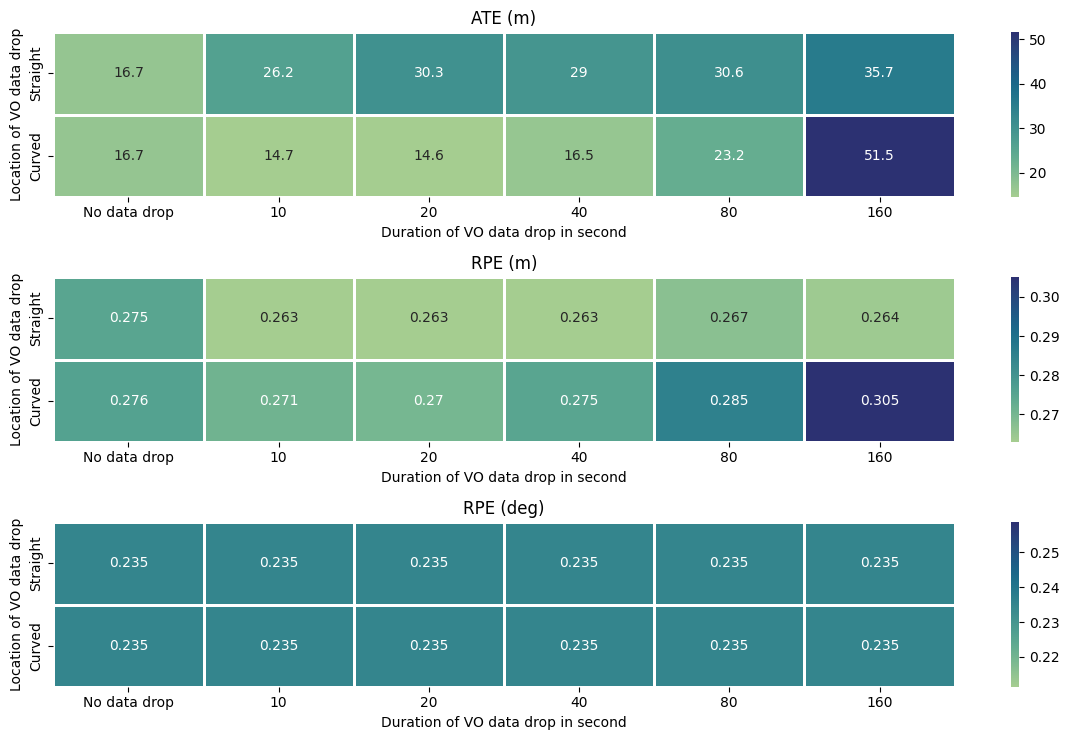

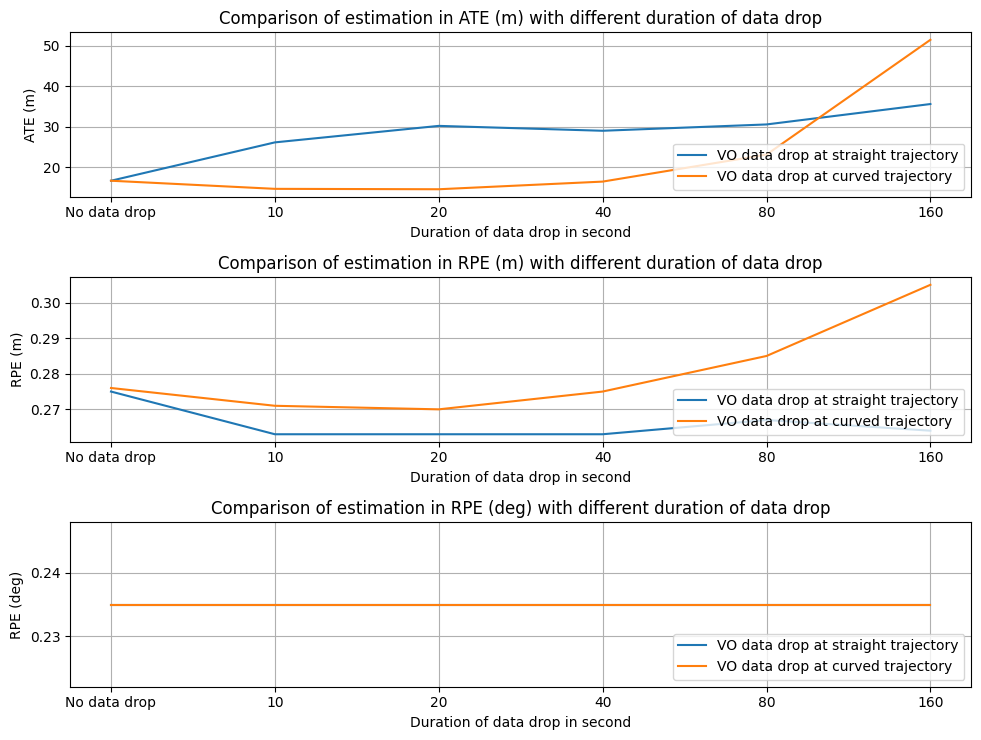

In [89]:
selected_metric = [indices[2], indices[3], indices[4]]

visualize_metric_on_heatmap(ekf_df_by_metric, selected_metric)

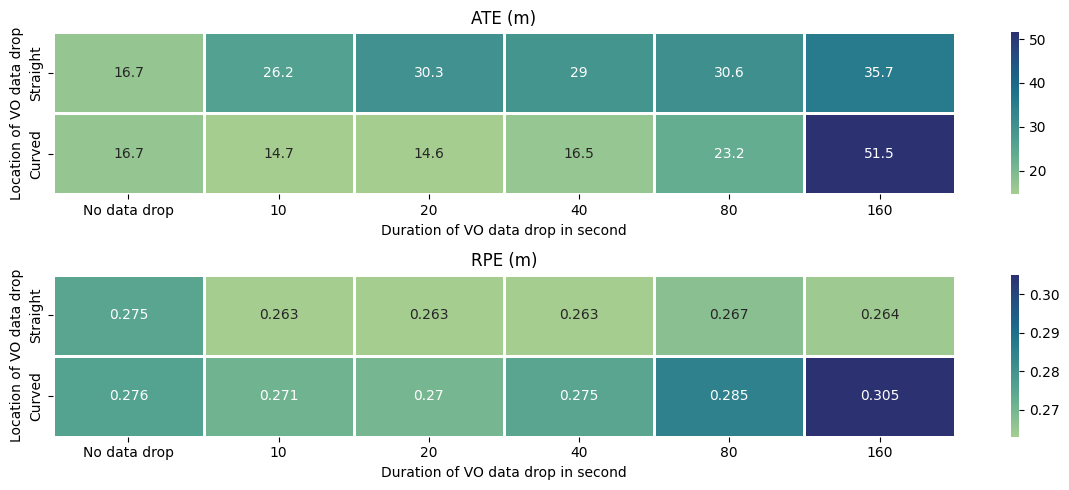

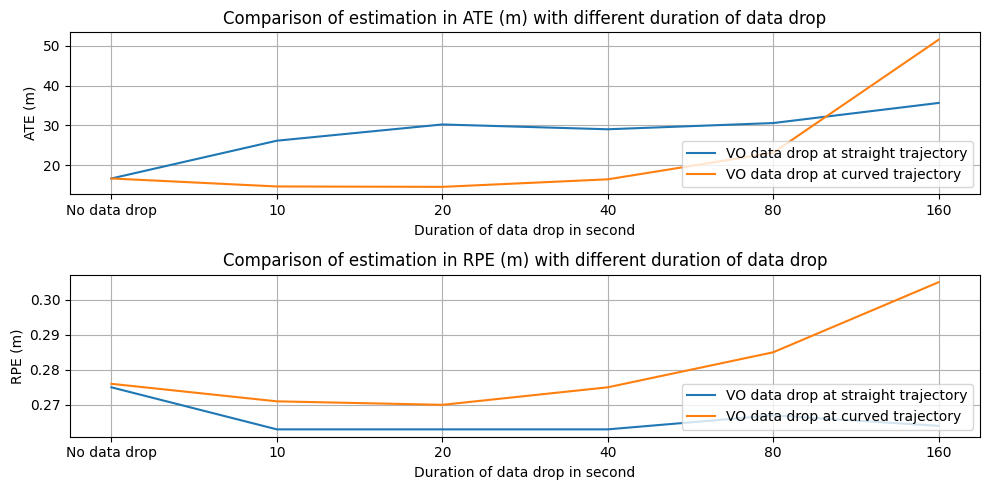

In [90]:
# Create a figure with specified layout
selected_metric = [indices[2], indices[3]]

visualize_metric_on_heatmap(ekf_df_by_metric, selected_metric)

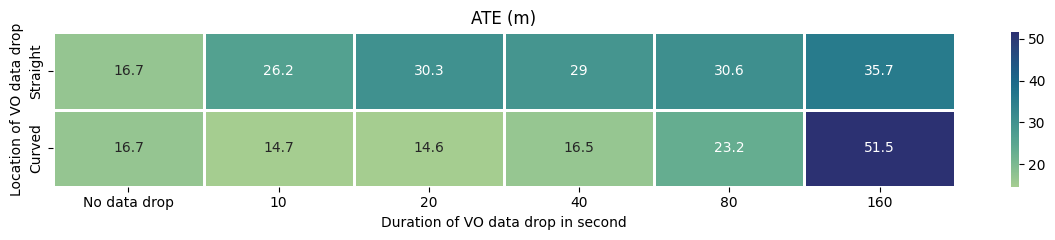

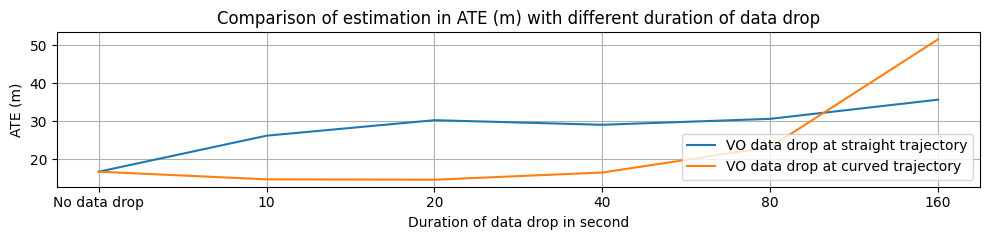

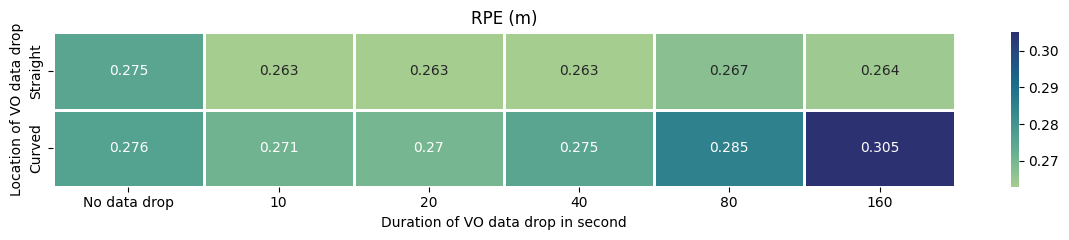

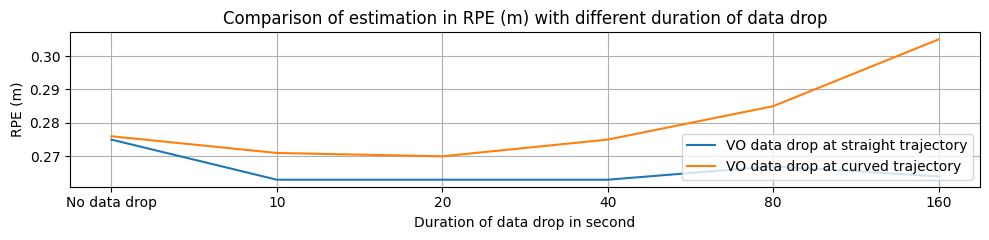

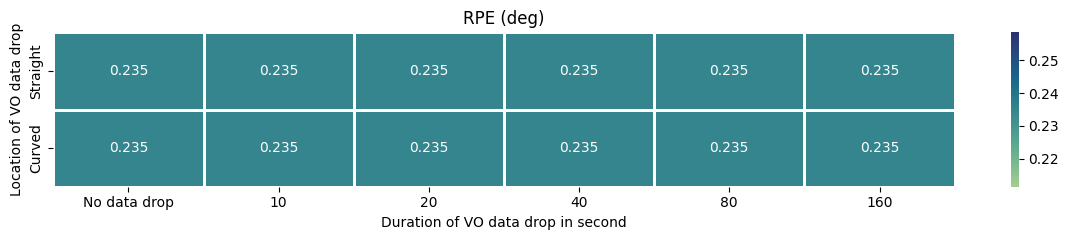

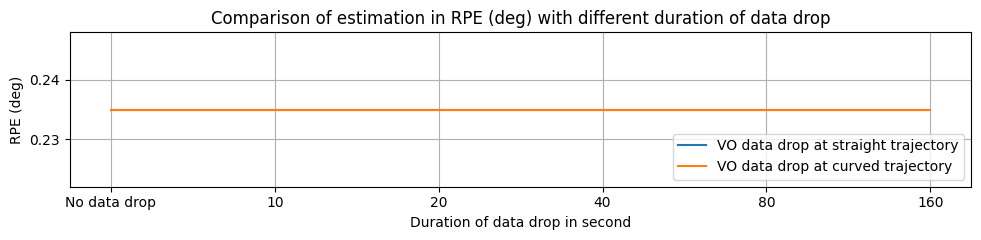

In [91]:
# Create a figure with specified layout
selected_metric = [indices[2]]

visualize_metric_on_heatmap(ekf_df_by_metric, selected_metric)

# Create a figure with specified layout
selected_metric = [indices[3]]

visualize_metric_on_heatmap(ekf_df_by_metric, selected_metric)

# Create a figure with specified layout
selected_metric = [indices[4]]

visualize_metric_on_heatmap(ekf_df_by_metric, selected_metric)

# CKF

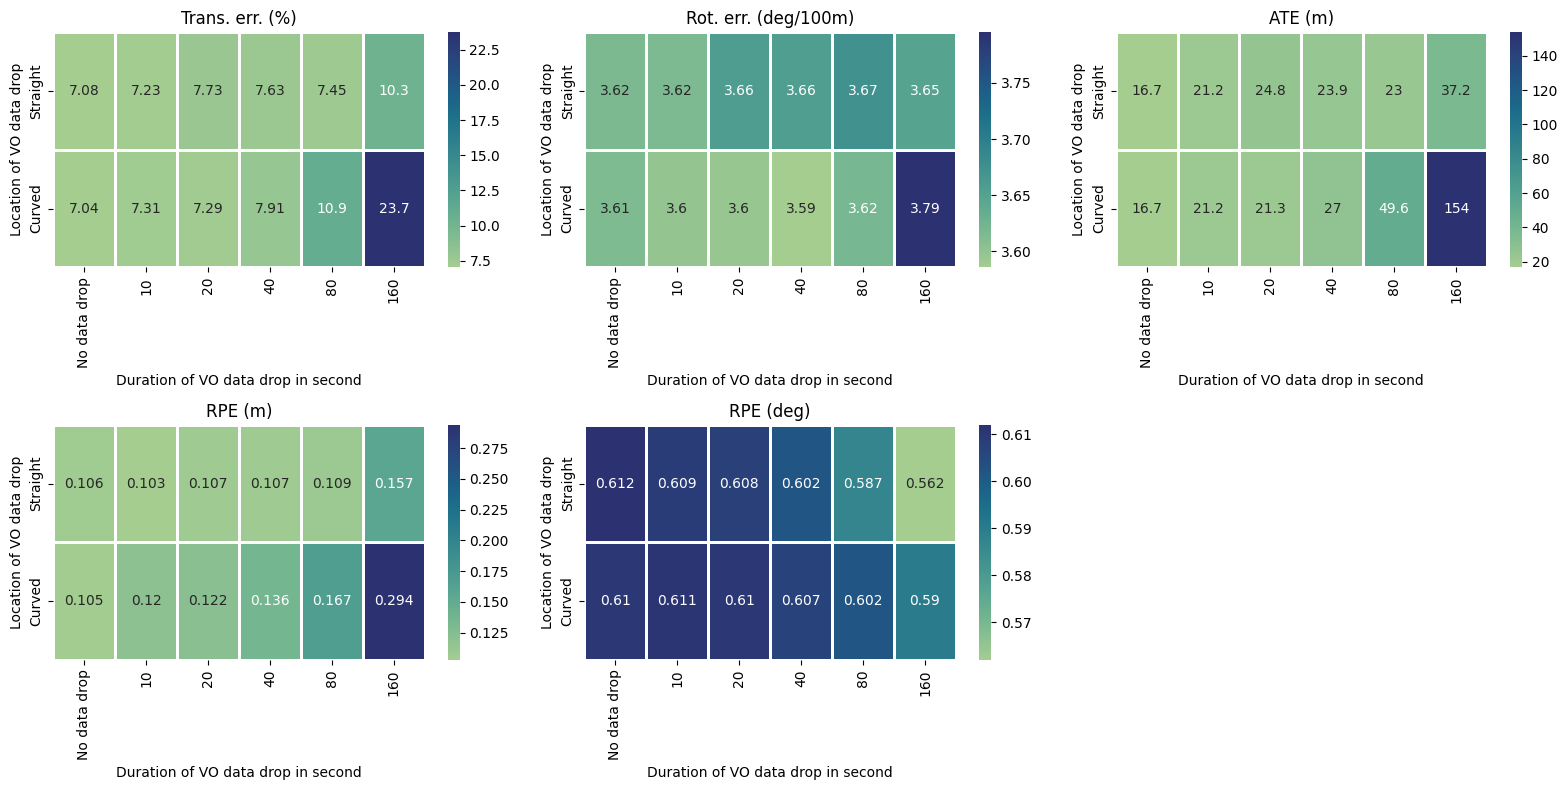

In [92]:
# Create a figure with specified layout
fig, (row1, row2) = plt.subplots(2, 3, figsize=(16, 8))
xlabel_text = "Duration of VO data drop in second"
ylabel_text = "Location of VO data drop"
for i, metric_name in enumerate(indices[:3]):
    # Plot the heatmaps
    sns.heatmap(
        ckf_df_by_metric[metric_name], 
        ax=row1[i], 
        cmap="crest",
        annot=True,
        linewidths=1,
        fmt='.3g',
    )
    
    row1[i].title.set_text(metric_name)
    row1[i].set(xlabel=xlabel_text, ylabel=ylabel_text)
    # Add a colorbar to the dedicated colorbar axis
    cmap = cm.get_cmap("crest")

for i, metric_name in enumerate(indices[3:]):
    # Plot the heatmaps
    sns.heatmap(
        ckf_df_by_metric[metric_name], 
        ax=row2[i], 
        cmap="crest",
        annot=True,
        linewidths=1,
        fmt='.3g',
    )

    row2[i].title.set_text(metric_name)   
    # Add a colorbar to the dedicated colorbar axis
    cmap = cm.get_cmap("crest")
    row2[i].set(xlabel=xlabel_text, ylabel=ylabel_text)

fig.delaxes(row2[2])
plt.tight_layout()
plt.show()


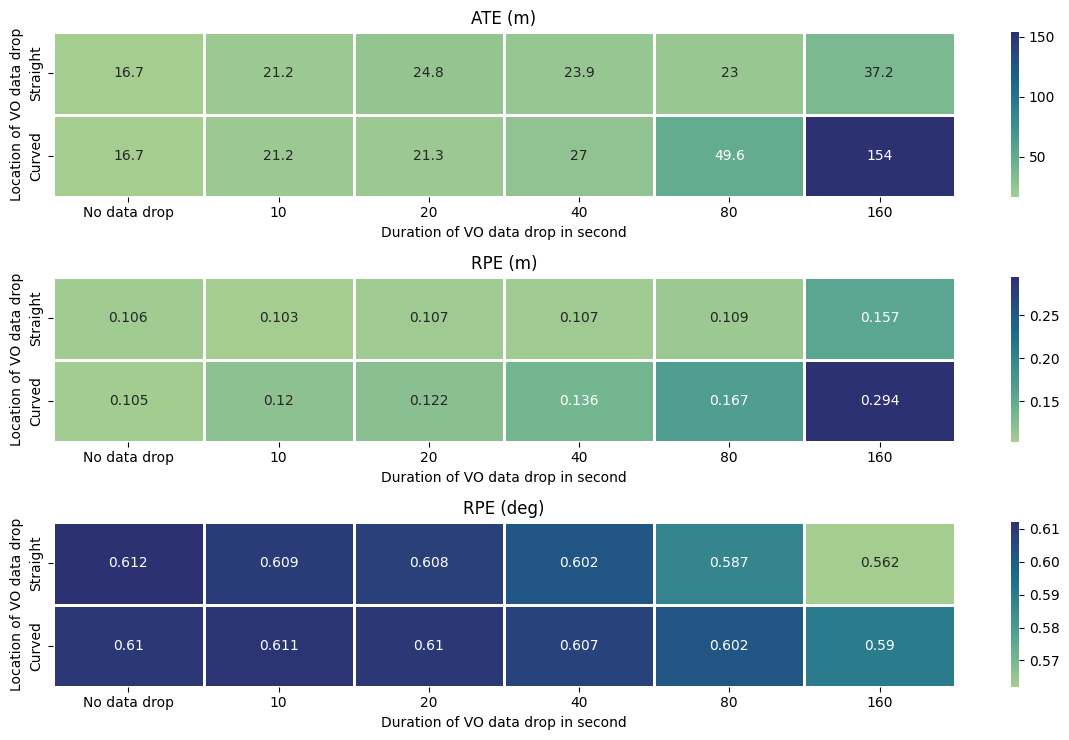

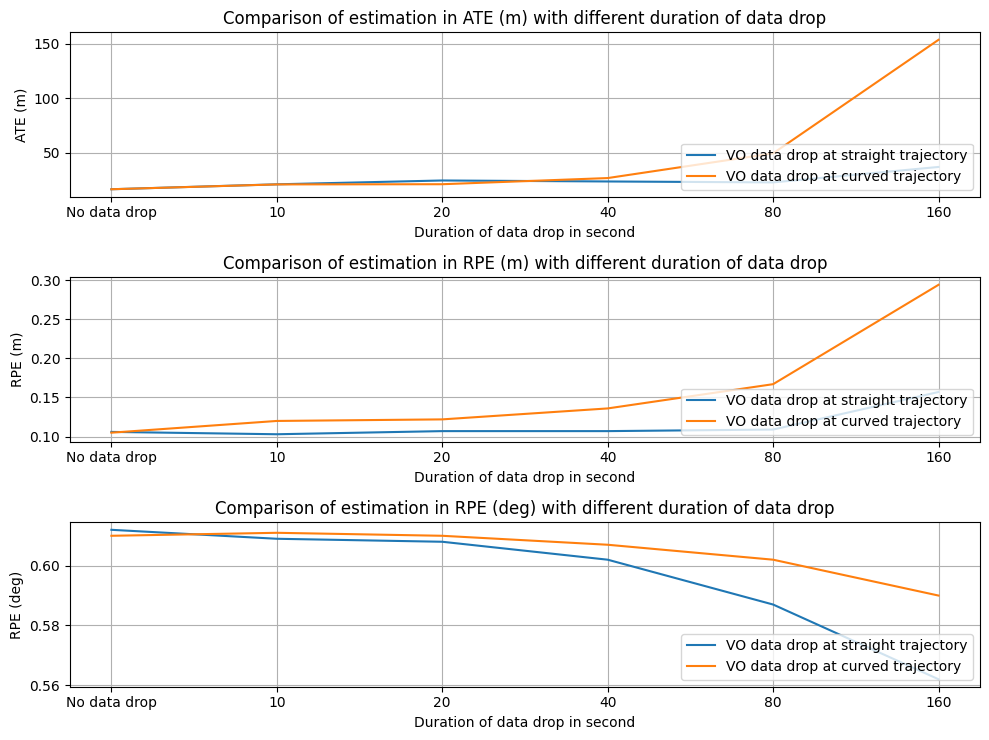

In [93]:
selected_metric = [indices[2], indices[3], indices[4]]

visualize_metric_on_heatmap(ckf_df_by_metric, selected_metric)

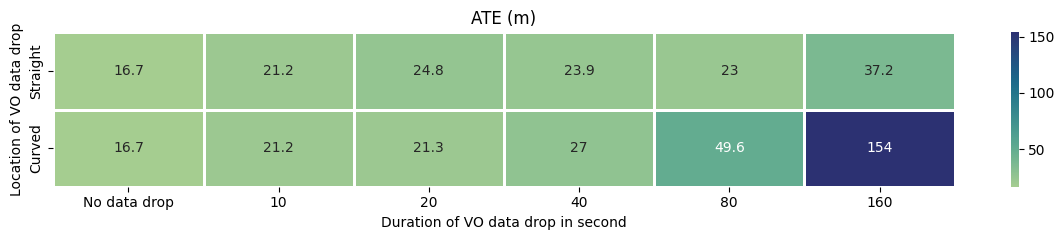

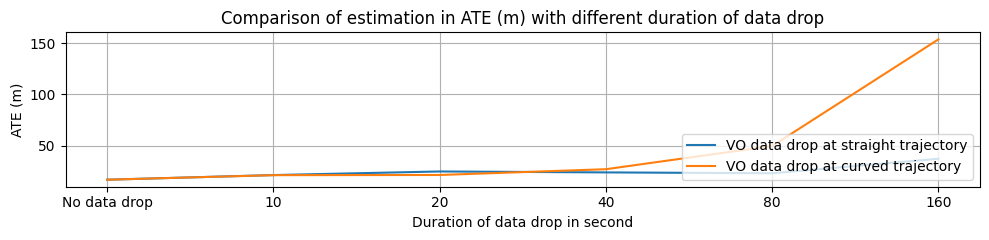

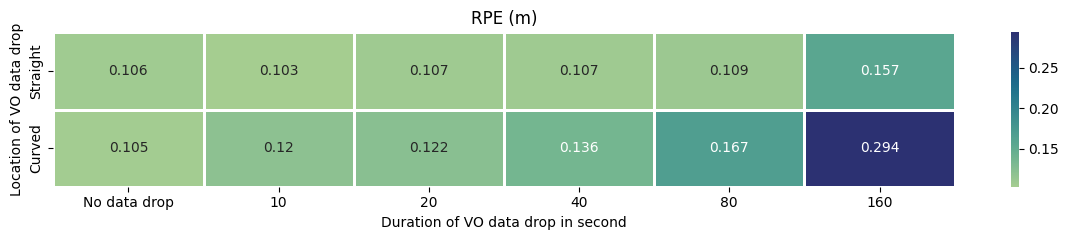

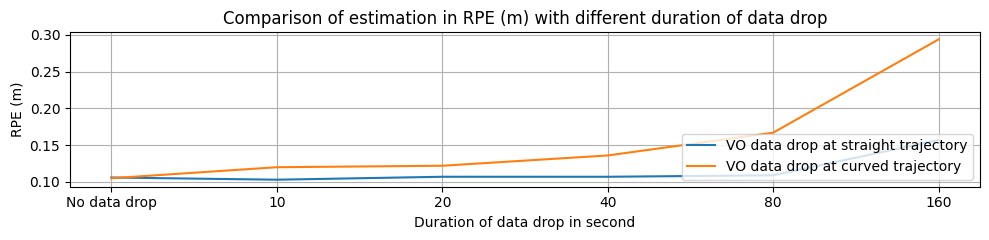

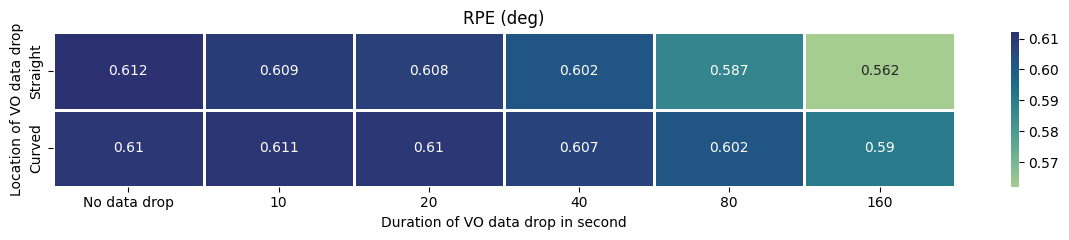

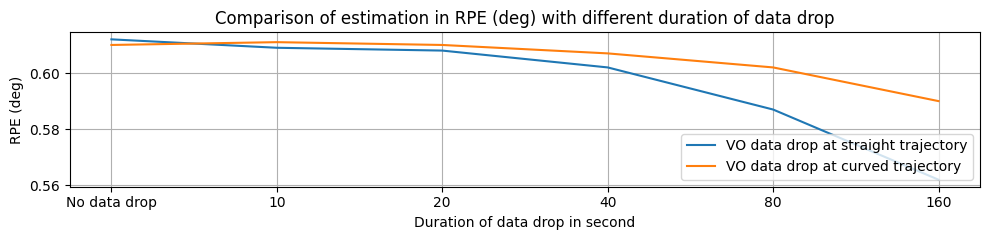

In [96]:
# Create a figure with specified layout
selected_metric = [indices[2]]

visualize_metric_on_heatmap(ckf_df_by_metric, selected_metric)

# Create a figure with specified layout
selected_metric = [indices[3]]

visualize_metric_on_heatmap(ckf_df_by_metric, selected_metric)

# Create a figure with specified layout
selected_metric = [indices[4]]

visualize_metric_on_heatmap(ckf_df_by_metric, selected_metric)

In [97]:
pd.DataFrame(
    np.array([
    ekf_df_by_metric[indices[0]].iloc[0].values,
    ckf_df_by_metric[indices[0]].iloc[0].values
    ]),
    index=["EKF", "CKF"],
    columns=ekf_df_by_metric[indices[0]].columns
)

,No data drop,10,20,40,80,160
EKF,7.167,6.193,6.494,6.575,7.199,8.420
CKF,7.080,7.229,7.726,7.627,7.447,10.348


In [98]:
# Create a figure with specified layout
def show_performance_by_metric(metric_name):
    fig, axs = plt.subplots(2, 1, figsize=(12, 5))
    axs[0].set_title(metric_name, size=18)
    curved = pd.DataFrame(
        np.array([
            ekf_df_by_metric[metric_name].iloc[0].values,
            ckf_df_by_metric[metric_name].iloc[0].values
        ]),
        index=["EKF", "CKF"],
        columns=ekf_df_by_metric[metric_name].columns
    )
    straight = pd.DataFrame(
        np.array([
            ekf_df_by_metric[metric_name].iloc[1].values,
            ckf_df_by_metric[metric_name].iloc[1].values
        ]),
        index=["EKF", "CKF"],
        columns=ekf_df_by_metric[metric_name].columns
    )
    # Plot the heatmaps
    sns.heatmap(
        curved, 
        ax=axs[0], 
        cmap="crest",
        annot=True,
        linewidths=1,
        fmt='.3g',
        annot_kws={'size': 16}
    )
    sns.heatmap(
        straight, 
        ax=axs[1], 
        cmap="crest",
        annot=True,
        linewidths=1,
        fmt='.3g',
        annot_kws={'size': 16}
    )
    

    xlabel = "Number of VO data loss in frames"
    # axs[0].set(xlabel=None, ylabel="VO data loss at curved line", size=16)
    axs[0].set_xlabel(None)
    axs[0].set_ylabel("VO data loss\n at curved line", fontsize=14)
    axs[1].set_xlabel(xlabel, fontsize=14)
    axs[1].set_ylabel(ylabel="VO data loss\n at straight line", fontsize=14)
    axs[0].tick_params(axis='both', which='major', labelsize=12)
    axs[1].tick_params(axis='both', which='major', labelsize=12)
    # Add a colorbar to the dedicated colorbar axis
    cmap = cm.get_cmap("crest")
    
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    linestyle_curved = "-"
    linestyle_straight = "--"
    ekf_color = "blue"
    x_axis = ekf_df_by_metric[metric_name].columns
    ax.plot(x_axis, ekf_df_by_metric[metric_name].iloc[0].values, color=ekf_color, linestyle=linestyle_straight, label="EKF with VO data drop at straight trajectory")
    ax.plot(x_axis, ekf_df_by_metric[metric_name].iloc[1].values, color=ekf_color, linestyle=linestyle_curved, label="EKF with VO data drop at curved trajectory")

    ckf_color = "red"
    x_axis = ckf_df_by_metric[metric_name].columns
    ax.plot(x_axis, ckf_df_by_metric[metric_name].iloc[0].values, color=ckf_color, linestyle=linestyle_straight, label="CKF with VO data drop at straight trajectory")
    ax.plot(x_axis, ckf_df_by_metric[metric_name].iloc[1].values, color=ckf_color, linestyle=linestyle_curved, label="CKF with VO data drop at curved trajectory")
    
    # ax.set(xlabel="Number of VO data loss in frames", ylabel=metric_name)
    ax.set_xlabel("Number of VO data loss in frames", fontsize=16)
    ax.set_ylabel(metric_name, fontsize=16)
    ax.title.set_text(f"Comparison of estimations of EKF and CKF in {metric_name} with different duration of data drop")
    ax.grid()
    ax.legend(loc="best")
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show()


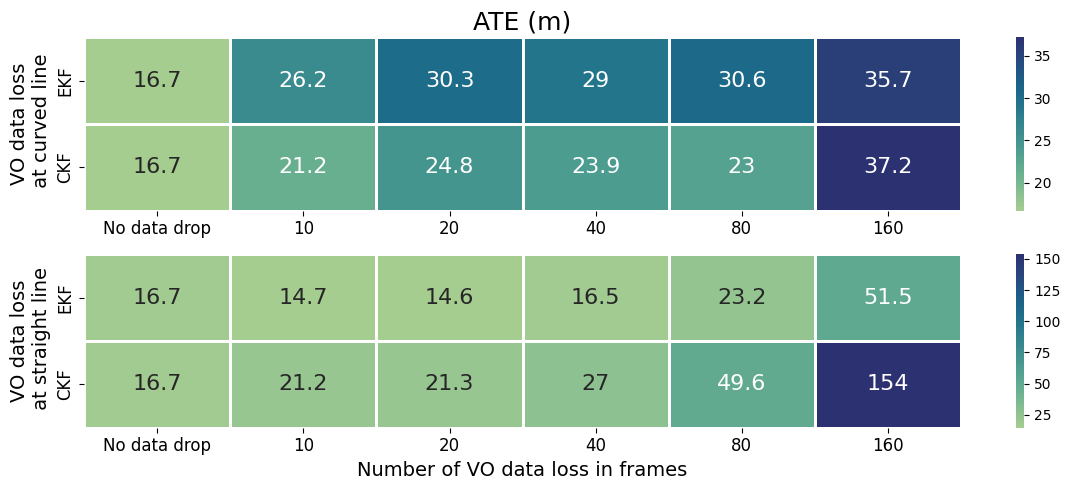

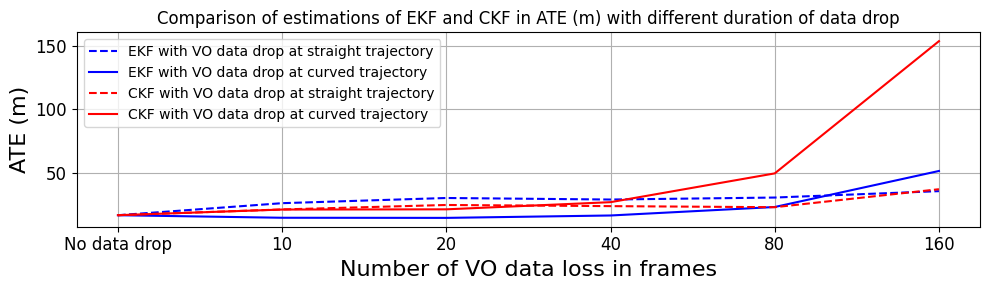

In [99]:
show_performance_by_metric(indices[2])

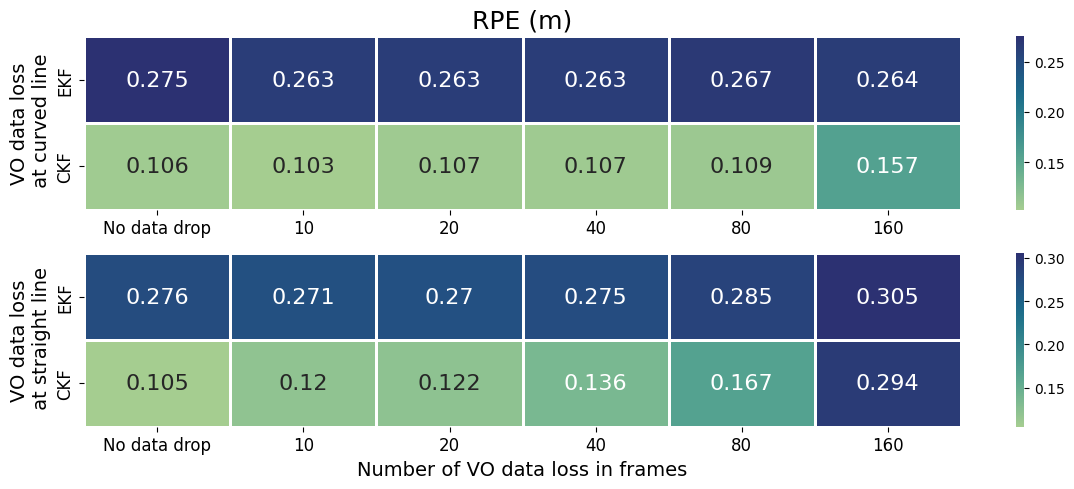

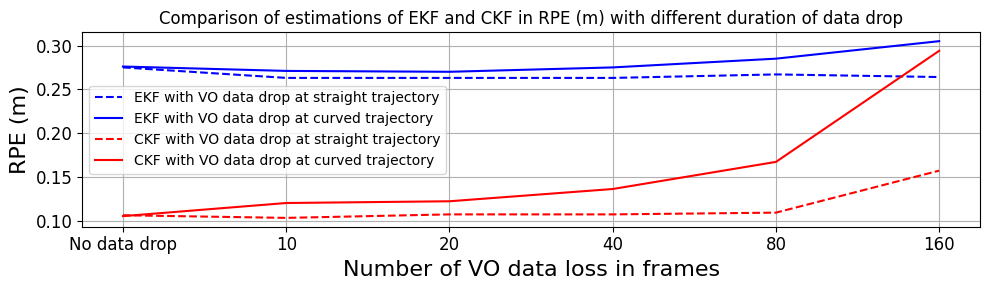

In [100]:
show_performance_by_metric(indices[3])

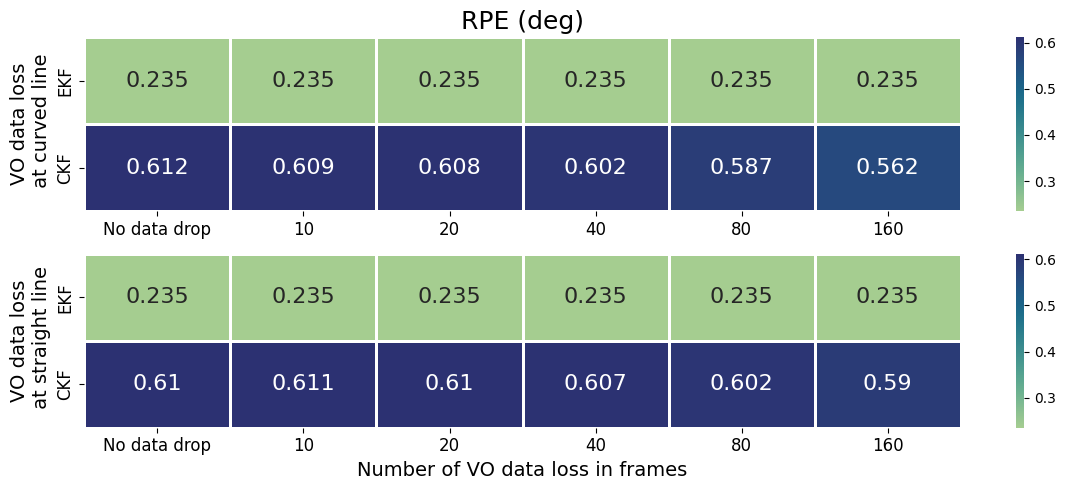

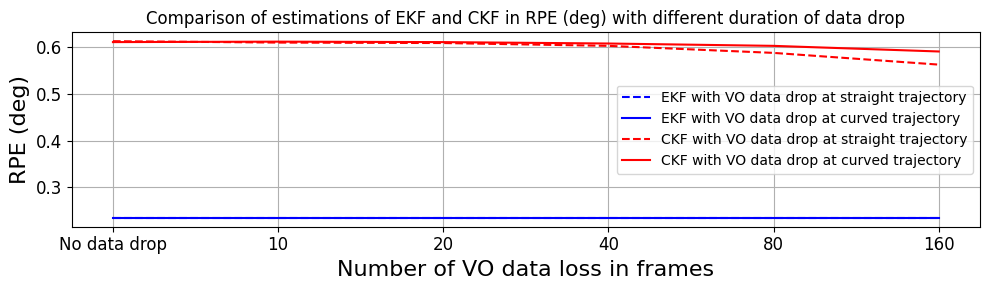

In [101]:
show_performance_by_metric(indices[4])

# Conclusion

'Straight'